# <font style="color: rgb(0,0,0);">Option B: </font> <font style="color: rgb(190,138,67);">Transport efficiency</font>

In [1]:
from PIL import Image, ImageTk, ImageMath, ImageOps
Image.MAX_IMAGE_PIXELS = 1000000000
import PIL.ImageGrab as ImageGrab
import cv2
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from io import StringIO
from csv import writer 
from scipy import integrate
import math
import time as time_lib
import xarray as xr
import subprocess
import json
from prettytable import *
import plotly.express as px

def current_milli_time():
    return round(time_lib.time() * 1000 *1000)

In [2]:
from A_helper_functions import *

# Trajectory: Target NRHO
Theoretical minimum via Hohmann-Transfers and impulsive maneuvers

| Maneuver | Description                                                            |
|-----------|------------------------------------------------------------------------|
| I         | a) Accelerate to orbital speed at h=0 from v0(Lat,Lon) <br> b) Raise Apo to LLO   |
| II        | Raise Peri to LLO                                                      |
| III       | Raise Apo to NRHO_Peri                                                 |
| IV        | a) Lon of ascending Node alignment <br> b) Raise Peri to become Apo with NRHO_Apo |

![image.png](doc/img/trajectory_merged.png)

## Initial Value: Height
64 pixels per degree Displacement Map <br>
23040 x 11520 tif (1012.6 MB)  float, 64 ppd <br>
[source] https://svs.gsfc.nasa.gov/4720

In [8]:
path = ".\sources\map\heightmap\ldem_64.tif"
height_data = np.array(Image.open(path))

display values (23040, 11520)
extrema -9.1145 10.757001
orderOfMagnitude(delta) 1
min_flat_value 1
inside normal bottom scaling
inter_steps 19 [-8.11450005 -7.11450005 -6.11450005 -5.11450005 -4.11450005 -3.11450005
 -2.11450005 -1.11450005 -0.11450005  0.88549995  1.88549995  2.88549995
  3.88549995  4.88549995  5.88549995  6.88549995  7.88549995  8.88549995
  9.88549995]
inter_steps 9 [-7.11450005 -5.11450005 -3.11450005 -1.11450005  0.88549995  2.88549995
  4.88549995  6.88549995  8.88549995]
image value spread [-9.11450005 -6.         -4.         -2.          0.          2.
  4.          6.          8.         10.75700092]
value_divided spread ['-9.11', '-6', '-4', '-2', '0', '2', '4', '6', '8', '10.76']


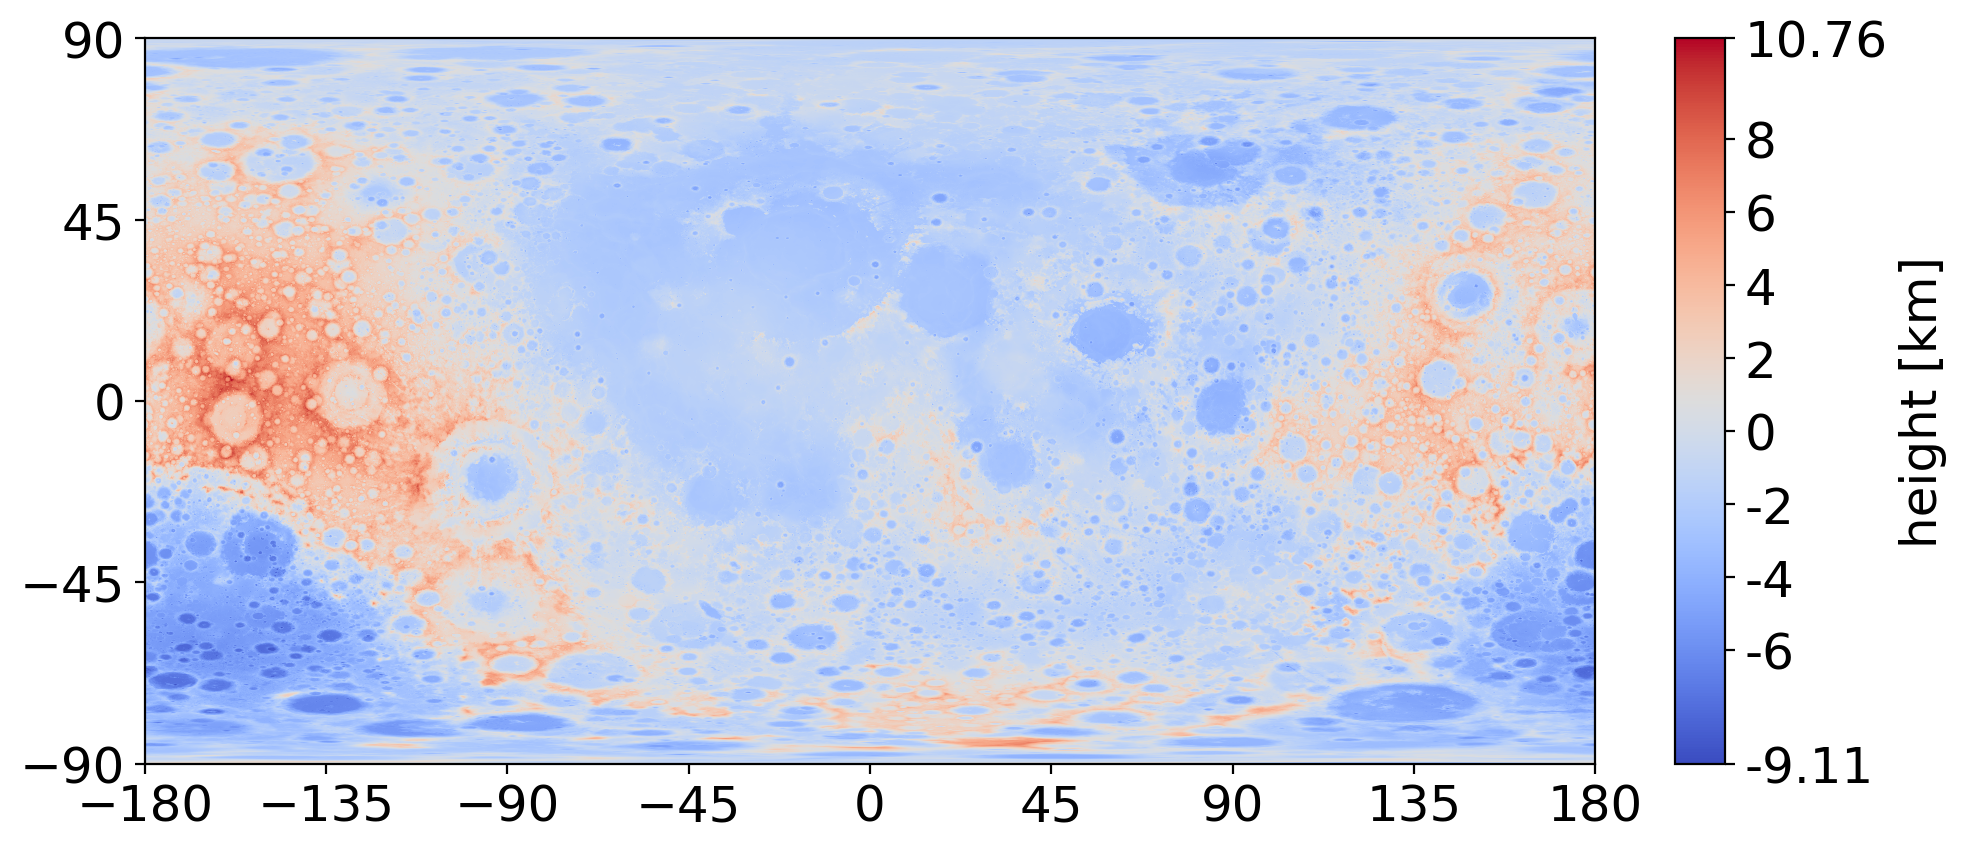

In [4]:
plot_map(height_data,1,'height [km]',tuple((-90,90)),tuple((-180,180)),labelsize=18,cmap='coolwarm',center_zero=True,i_steps=[-6,-4,-2,0,2,4,6,8],save="Heightmap.png")

## Initial Value: Ground Speed
Assuming perfect sphere with T = 27.321661 days
<br>
Calculate ground velocity as a fuction from location (Lattitude) over angular speed of the moon.
<br>
ground_speed_map of the shape of height_data

In [13]:
def ground_vel(Lat):
    omega = 2 * np.pi / 2.360592E6 # [s] = (2pi/27.321661 [days])
    v_ground = omega * r_surface(Lat) # [m/s] into direction of turn
    return v_ground

def r_surface(Lat):
    r_axis = np.cos(np.deg2rad(Lat)) * r_moon
    return r_axis

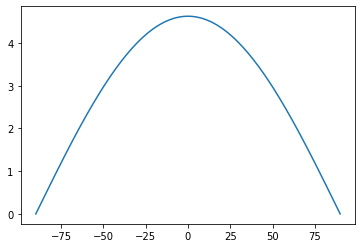

In [14]:
test_Lat = np.linspace(-90,90,180)
test_y = ground_vel(test_Lat)
plt.plot(test_Lat,test_y)
plt.show()

In [15]:
# Create a Map with the shape of height_data.shape
Lat_steps_n = height_data.shape[0]
ground_speed_Lat_vec = np.zeros(Lat_steps_n)
for i in range(Lat_steps_n):
    Lat = 90 - i * 180/Lat_steps_n - 0.5* 180/Lat_steps_n
    ground_speed_Lat_vec[i] = ground_vel(Lat)
ground_speed_data = np.transpose(ground_speed_Lat_vec* np.transpose(np.array([[1]*height_data.shape[1]])))

In [16]:
print(ground_speed_data)

[[0.00063056 0.00063056 0.00063056 ... 0.00063056 0.00063056 0.00063056]
 [0.00189168 0.00189168 0.00189168 ... 0.00189168 0.00189168 0.00189168]
 [0.0031528  0.0031528  0.0031528  ... 0.0031528  0.0031528  0.0031528 ]
 ...
 [0.0031528  0.0031528  0.0031528  ... 0.0031528  0.0031528  0.0031528 ]
 [0.00189168 0.00189168 0.00189168 ... 0.00189168 0.00189168 0.00189168]
 [0.00063056 0.00063056 0.00063056 ... 0.00063056 0.00063056 0.00063056]]


display values (23040, 11520)
extrema 0.0006305596132611883 4.624435756459766
orderOfMagnitude(delta) 0
min_flat_value 0.0001
inside normal bottom scaling
inter_steps 46 [0.10063056 0.20063056 0.30063056 0.40063056 0.50063056 0.60063056
 0.70063056 0.80063056 0.90063056 1.00063056 1.10063056 1.20063056
 1.30063056 1.40063056 1.50063056 1.60063056 1.70063056 1.80063056
 1.90063056 2.00063056 2.10063056 2.20063056 2.30063056 2.40063056
 2.50063056 2.60063056 2.70063056 2.80063056 2.90063056 3.00063056
 3.10063056 3.20063056 3.30063056 3.40063056 3.50063056 3.60063056
 3.70063056 3.80063056 3.90063056 4.00063056 4.10063056 4.20063056
 4.30063056 4.40063056 4.50063056 4.60063056]
inter_steps 23 [0.20063056 0.40063056 0.60063056 0.80063056 1.00063056 1.20063056
 1.40063056 1.60063056 1.80063056 2.00063056 2.20063056 2.40063056
 2.60063056 2.80063056 3.00063056 3.20063056 3.40063056 3.60063056
 3.80063056 4.00063056 4.20063056 4.40063056 4.60063056]
image value spread [6.30559613e-04 1.00000

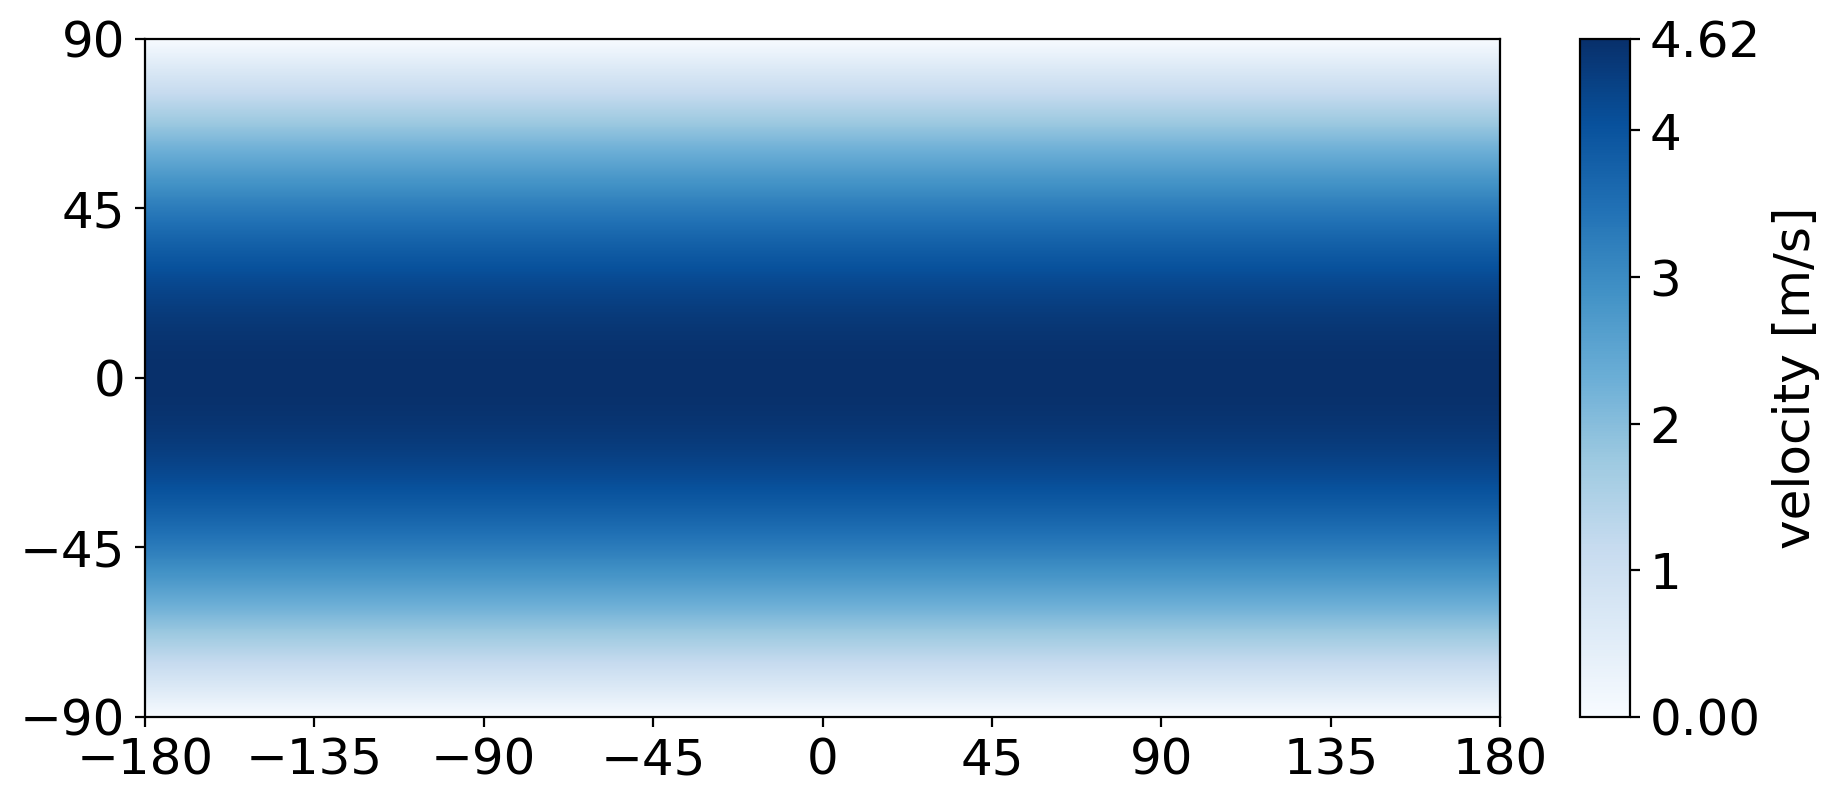

In [17]:
plot_map(ground_speed_data,1,'velocity [m/s]',tuple((-90,90)),tuple((-180,180)),labelsize=18,cmap='Blues',i_steps=[1,2,3,4],save="ground_speed.png")

## Maneuvers

In [18]:
def orb_vel(r):
    return np.sqrt((G * m_moon)/(r)) # [m/s]

def orb_vel_ellip(r,a):
    return np.sqrt((G * m_moon) * ( (2/r)-(1/a) )) # [m/s]

In [19]:
# Heightmap extrema:   min:    -9.115 [km]   max:    10.757 [km] to reference radius 1737.4 [km]
# Radius extrema:      min:  1728.285 [km]   max:  1748.157 [km]
# Orbital radius LLO:        1750.157 [km]  <- 2 km over highest point
# Altitude  gain:      max:    21.872 [km]   min:     2.000 [km]

orbital_r = 1_750_157 # [m] LLO
NHRO_r_peri = 3_000_000 + r_moon # [m]
NHRO_r_apo = 70_000_000 + r_moon # [m]

### I) Ascent
- from h0,v0 to orbital speed on ground level
- raise Apo to LLO
(initiate first Hohman transfer)

In [20]:
# deltaV from start_radius with v=0 to orbital_radius:
# IDEAL SEQUENCE:
#    v1 - a) instantaneous burn to orbital velocity at ground level while countering ground velocity
#       - b) initiate Hohman Transfer (Raise Apo to LLO)
#    v2 - Hohman Transfer from start_radius to orbital_radius

def maneuver_I(start_r, start_vel):
    v0 = start_vel
    a = (start_r + orbital_r)/2 # [m] semi major axis of transfer ellipse to LLO
    v1 = orb_vel(start_r)
    v2_H1 = orb_vel_ellip(start_r,a) - orb_vel(start_r)
    
    dv_m1 = np.sqrt(v0**2 + (v1 + v2_H1)**2) # vector norm - v0 is perpendicular to v1 and v2_H1
    return dv_m1 # [m/s]

### II) LLO circularization
- Raise Peri to LLO (finish first Hohman Transfer)

In [21]:
def maneuver_II(start_r):
    a = (start_r + orbital_r)/2 # [m] semi major axis of transfer ellipse to LLO
    v2_H2 = orb_vel(orbital_r) - orb_vel_ellip(orbital_r,a)
    
    return v2_H2 # [m/s]

### III) Raise Apo to NRHO_Peri
- Raise Apo to NRHO_Peri (initiate second Hohman transfer)

In [22]:
def maneuver_III():
    a1 = (orbital_r + NHRO_r_peri)/2 # [m] semi major axis of transfer ellipse from LLO to NRHO
    v3 = orb_vel_ellip(orbital_r,a1) - orb_vel(orbital_r)
    
    return v3 # [m/s]

### VI) Raise Peri to become Apo with NRHO_Apo
- Raise Peri (finish second Hohman transfer), Peri becomes Apo
- Raise Apo to NRHO Apo

In [23]:
def maneuver_VI():
    a1 = (orbital_r + NHRO_r_peri)/2  # [m] semi major axis of transfer ellipse from LLO to NRHO
    a2 = (NHRO_r_apo + NHRO_r_peri)/2 # [m] semi major axis of NRHO ellipse
    v4 = orb_vel_ellip(NHRO_r_peri,a2) - orb_vel_ellip(NHRO_r_peri,a1)
    
    return v4 # [m/s]

## Combined Maneuvers

In [24]:
# this step needs approx. 1 min to complete

r_data = height_data*1000+r_moon

dv_NRHO_1 = maneuver_I(r_data,ground_speed_data)
dv_NRHO_2 = maneuver_II(r_data)
dv_NRHO_3 = maneuver_III()
dv_NRHO_4 = maneuver_VI()

dv_map_NRHO = dv_NRHO_1 + dv_NRHO_2 + dv_NRHO_3 + dv_NRHO_4 # [m/s]

dv_NRHO_est = np.max( 1.2*(dv_NRHO_1 + dv_NRHO_2) + dv_NRHO_3 + dv_NRHO_4) # [m/s] 20% margin on I and II for a more realistic ascent

In [25]:
print(f'dv_I:  {np.min(dv_NRHO_1):0.2f} - {np.max(dv_NRHO_1):0.2f} [m/s]')
print(f'dv_II: {np.min(dv_NRHO_2):0.2f} - {np.max(dv_NRHO_2):0.2f} [m/s]')
print(f'dv_III: {dv_NRHO_3:0.2f} [m/s]')
print(f'dv_IV:  {dv_NRHO_4:0.2f} [m/s]')
print()
print(f'Total dv to NRHO: {np.min(dv_map_NRHO):0.5f} - {np.max(dv_map_NRHO):0.5f} [m/s]')
print(f'max with margin:  {dv_NRHO_est:0.2f} [m/s]')

dv_I:  1675.19 - 1689.59 [m/s]
dv_II: 0.48 - 5.27 [m/s]
dv_III: 348.97 [m/s]
dv_IV:  646.18 [m/s]

Total dv to NRHO: 2670.81020 - 2690.00489 [m/s]
max with margin:  3028.98 [m/s]


In [26]:
# cutting of precision to save on filesize (min = 2670.81020 -> 2670.81030, max = 2690.00489 -> 2690.00488)
print(f'from  {dv_map_NRHO.dtype} {type(dv_map_NRHO)} {dv_map_NRHO.dtype.itemsize*dv_map_NRHO.shape[0]*dv_map_NRHO.shape[1]/(1024*1024*1024):0.2f} GB')
dv_map_NRHO = dv_map_NRHO.astype(np.float32, copy=False)
print(f'to    {dv_map_NRHO.dtype} {type(dv_map_NRHO)} {dv_map_NRHO.dtype.itemsize*dv_map_NRHO.shape[0]*dv_map_NRHO.shape[1]/(1024*1024*1024):0.2f} GB')

from  float64 <class 'numpy.ndarray'> 1.98 GB
to    float32 <class 'numpy.ndarray'> 0.99 GB


In [35]:
# save data in xArray to file (~1GB of space)

Lat, Lon = LatLonfromShape(height_data.shape)

xA_dv_map_NRHO = xr.DataArray(
    data=dv_map_NRHO,
    dims=["lat","lon"],
    coords=dict(
        lon=(["lon"], Lon),
        lat=(["lat"], Lat)
    ),
    attrs=dict(
        description="DeltaV to Lunar Gateway (NRHO)",
        var_desc="deltaV",
        units="m/s",
    ),
)

xA_dv_map_NRHO.to_netcdf("maps/dv_map_NRHO.nc")

In [5]:
# load xArray from file
xA_dv_map_NRHO = xr.open_dataarray("maps/dv_map_NRHO.nc")
dv_map_NRHO = xA_dv_map_NRHO.data

display values (23040, 11520)
extrema 2670.8103 2690.005
orderOfMagnitude(delta) 1
min_flat_value 1000
inside normal bottom scaling
inter_steps 19 [2671.81030273 2672.81030273 2673.81030273 2674.81030273 2675.81030273
 2676.81030273 2677.81030273 2678.81030273 2679.81030273 2680.81030273
 2681.81030273 2682.81030273 2683.81030273 2684.81030273 2685.81030273
 2686.81030273 2687.81030273 2688.81030273 2689.81030273]
inter_steps 9 [2672.81030273 2674.81030273 2676.81030273 2678.81030273 2680.81030273
 2682.81030273 2684.81030273 2686.81030273 2688.81030273]
image value spread [2670.81030273 2672.81030273 2674.81030273 2676.81030273 2678.81030273
 2680.81030273 2682.81030273 2684.81030273 2686.81030273 2688.81030273
 2690.00488281]
value_divided spread ['2670.81', '2673', '2675', '2677', '2679', '2681', '2683', '2685', '2687', '2689', '2690.00']


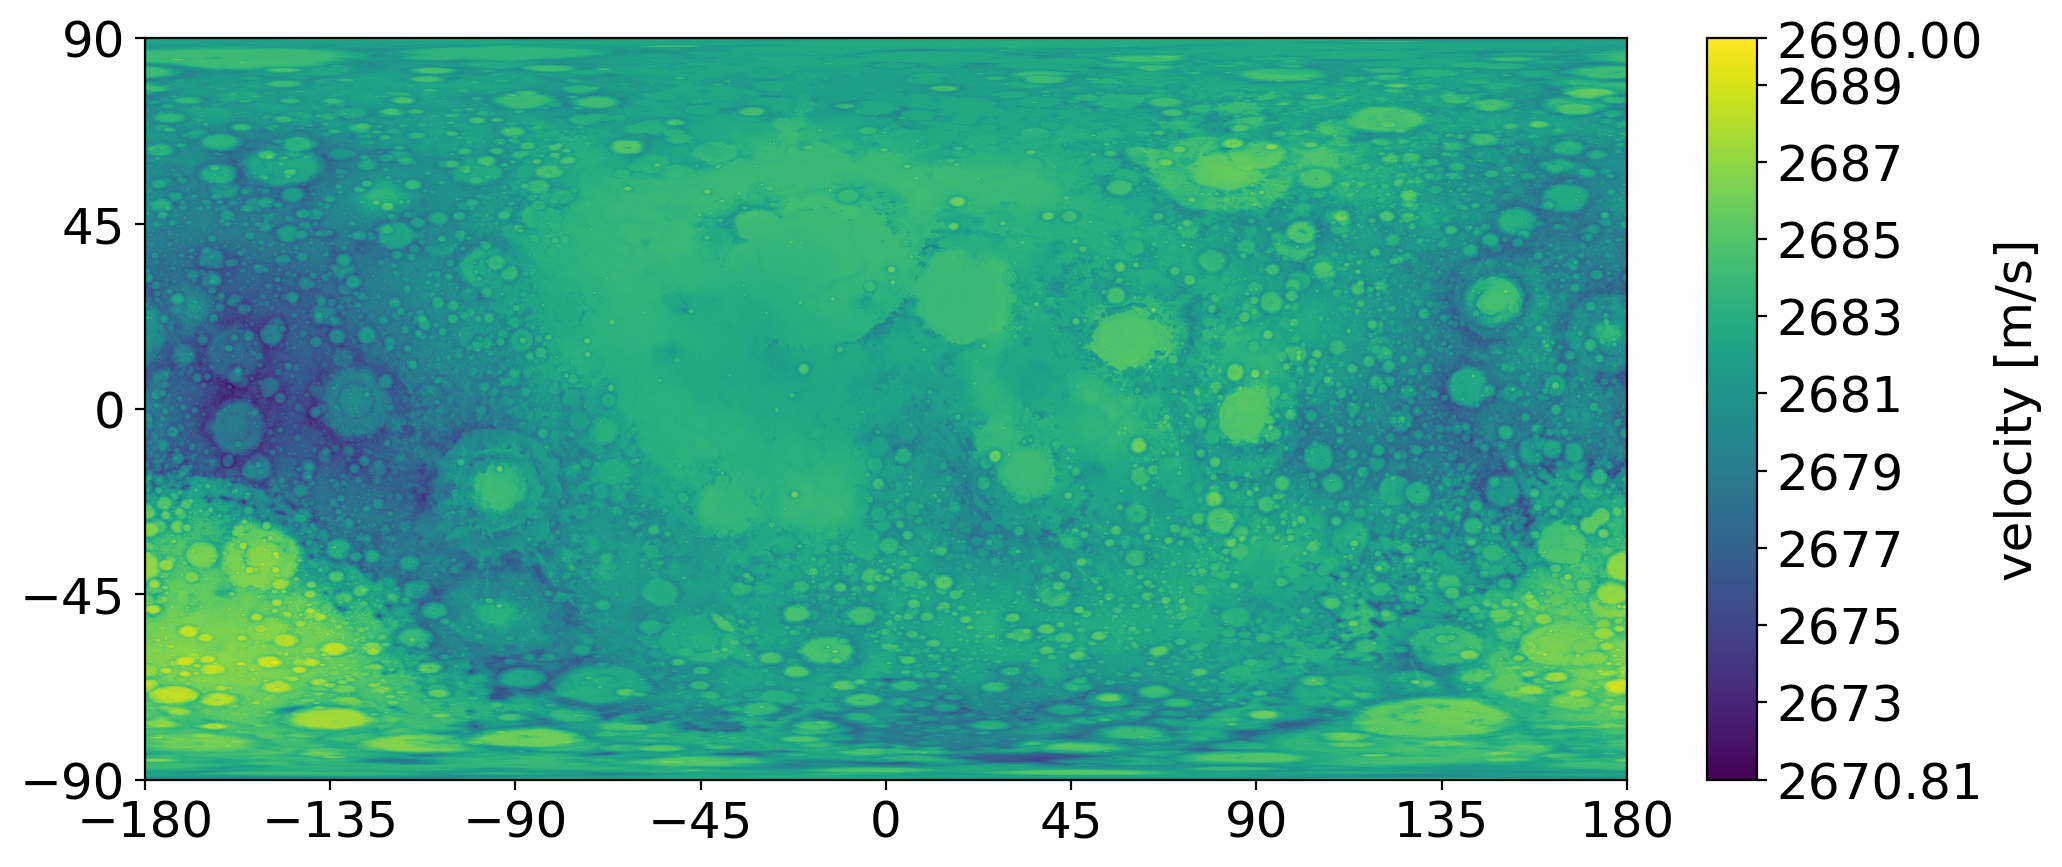

In [5]:
plot_map(dv_map_NRHO,1,'velocity [m/s]',tuple((-90,90)),tuple((-180,180)),labelsize=18,save="dv_map_NRHO.png")

## EL3 Sizing - Roundtrip Estimation
    → [1] Moon surface: load Payload (O2), refuel O2
    → [2] Transfer (Launch + Maneuvers)
    → [3] Destination: deliver Payload (O2), refuel H2
    → [4] Transfer (Launch + Maneuvers)
    → [1] ...

In [27]:
# EL3 initial data
# https://www.esa.int/Science_Exploration/Human_and_Robotic_Exploration/Exploration/Argonaut_European_Large_Logistics_Lander
EL3_wet_mass  = 8500 # [kg]
EL3_dry_mass  = 3100 # [kg]
EL3_prop_mass = EL3_wet_mass - EL3_dry_mass # [kg]
EL3_payload   = 1500 # [kg]

# EL3 assumption
EL3_I_sp = 400 # [s] specific impulse


In [28]:
def maneuver_result_mass(EEV,m_0,deltaV):
    # from: deltaV = EEV * ln ( m_0 / m_f )
    m_f = m_0 * (1/ np.exp(deltaV/EEV))
    return m_f

def check_fuel(H2,O2,result_table):
    if O2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "", "EMPTY", "" ])
        return False
    elif H2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "EMPTY", "", "" ])
        return False
    else:
        return True

# roundtrip calculation via deltaV estimations
def compute_roundtrip(dv, mass_full, payload, H2_initial, H2_refill, dest_name="Destination",printout=False):
    
    mass_dry = 1600
    of_ratio = 3
    I_sp = 400 # [s] specific impulse
    EEV = np.array(I_sp * g_0, dtype=np.float64) # [m/s] effective exhaust velocity
    
    initial_height = -9115 #-8.179428100585938 # lowest point on downsampled map
    mass = mass_full
    fuel = mass_full - mass_dry - payload
    H2_factor = (1/(of_ratio+1))
    O2_factor = (of_ratio/(of_ratio+1))
    H2 = H2_initial
    O2 = fuel - H2
    
    H2_initial = H2 # for comparing to the end state

    
    #logging in table
    result_table = PrettyTable([" ", "ΔV", "used fuel", "Δ H2", "Δ O2","mass","fuel left","H2","O2","payload"],float_format = "4.0")
    result_table.set_style(MARKDOWN)
    msg = False
    msg_H2 = False
    msg_O2 = False
    
    
    #__________________________________
    # Lunar surface starting condition
    result_table.add_row(["Lunar Surface", "", "", "" , f"+{O2}" , mass, fuel, H2, O2, f'+{payload}' ])
    
    #__________________________________
    # apply launch and maneuver segment
    
    fuel_used = mass - maneuver_result_mass(EEV,mass,dv)
    fuel -= fuel_used
    H2 -= H2_factor * fuel_used
    O2 -= O2_factor * fuel_used
    mass = mass_dry + fuel + payload
    
    result_table.add_row(["Maneuvers", dv, fuel_used, -H2_factor * fuel_used, -O2_factor * fuel_used, mass, fuel, H2, O2, "" ])
    
    # check if fuel empty
    if O2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "", "EMPTY", "" ])
        if printout: print(result_table, end="\n \n")
        return "O2 empty", msg
    elif H2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "EMPTY", "", "" ])
        if printout: print(result_table, end="\n \n")
        return "H2 empty", msg
    
    # check H2 for optimization
    if H2 < 1 and H2 > 0:
        msg_H2 = True
    if H2 > 1:
        msg = "H2 leftover"
    
    #__________________________________
    # Gateway exchange
    
    H2 += H2_refill
    fuel = O2 + H2
    mass = mass_dry + fuel
    
    result_table.add_row(["Gateway exchange", "", "", "+"+str(H2_refill),"", mass, fuel, H2, O2, "-"+str(payload) ])
    
    # check if fuel empty
    if O2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "", "EMPTY", "" ])
        if printout: print(result_table, end="\n \n")
        return "O2 empty", msg
    elif H2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "EMPTY", "", "" ])
        if printout: print(result_table, end="\n \n")
        return "H2 empty", msg
    
    #__________________________________
    # apply maneuver and landing segment
    
    fuel_used = mass - maneuver_result_mass(EEV,mass,dv)
    fuel -= fuel_used
    H2 -= H2_factor * fuel_used
    O2 -= O2_factor * fuel_used
    mass = mass_dry + fuel + payload
    
    result_table.add_row(["Maneuvers", dv , fuel_used, -H2_factor * fuel_used, -O2_factor * fuel_used, mass, fuel, H2, O2, "" ])
    
    # check if fuel empty
    if O2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "", "EMPTY", "" ])
        if printout: print(result_table, end="\n \n")
        return "O2 empty", msg
    elif H2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "EMPTY", "", "" ])
        if printout: print(result_table, end="\n \n")
        return "H2 empty", msg
    
    if H2 < H2_initial:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "EMPTY", "", "" ])
        if printout: print(result_table, end="\n \n")
        return "H2 insufficient", msg
    
    # check O2 for optimization
    if O2 < 1 and O2 > 0:
        msg_O2 = True
    if O2 > 1:
        msg = "O2 leftover"
    
    if msg_H2 == True and msg_O2 == True:
        msg = True
    
    result_table.add_row(["=== SUCCESS ===", "====", "====", "====" , "====" , "====", "====", "====", "====", "====" ])
    if printout: print(result_table, end="\n \n")
    return True, msg

In [29]:
# normal EL3 config is insufficient
compute_roundtrip(dv=np.min(dv_map_NRHO),mass_full=8500,payload=1500,H2_initial=1049.5,H2_refill=1701,dest_name="NRHO",printout=True)

|                  |     ΔV    | used fuel |  Δ H2 |   Δ O2  | mass | fuel left |  H2  |   O2  | payload |
|:----------------:|:---------:|:---------:|:-----:|:-------:|:----:|:---------:|:----:|:-----:|:-------:|
|  Lunar Surface   |           |           |       | +4350.5 | 8500 |    5400   | 1050 |  4350 |  +1500  |
|    Maneuvers     | 2670.8103 |    4197   | -1049 |  -3148  | 4303 |    1203   |    0 |  1202 |         |
| Gateway exchange |           |           | +1701 |         | 4504 |    2904   | 1701 |  1202 |  -1500  |
|    Maneuvers     | 2670.8103 |    2224   |  -556 |  -1668  | 3780 |     680   | 1145 |  -466 |         |
|      ABORT       |           |           |       |         |      |           |      | EMPTY |         |
 


('O2 empty', False)

### Upscaling
Because the standard EL3 configuration is insufficient to carry out the roundtrip<br>
> the launcher (propellant) is scaled up, while keeping the mass_dry constant at 1600 kg
<br>

Assumption: the propulsion system still carries out maneuvers as estimated and structure mass stays constant<br>
Limitation: mass ratio increases with upscaling - pseudo efficiency increase

In [30]:
def converge_NRHO_roundtrip(payload,dv,dest_name="NRHO",silent=False,info=False):
    # init values
    wet_mass_loop = 2*payload # for faster convergence
    H2_initial_loop = 100
    H2_refill_loop = 100
    
    while True:
        ans, msg = False, False
        ans, msg = compute_roundtrip(dv,wet_mass_loop,payload,H2_initial_loop,H2_refill_loop,dest_name)
        if ans == "O2 empty":
            if payload > 20000: wet_mass_loop += 100 # for faster convergence with big rockets
            else: wet_mass_loop += 1
        if ans == "H2 empty":
            H2_initial_loop += 1
            H2_refill_loop += 1
        if ans == "H2 insufficient":
            H2_refill_loop += 1
        if msg == "H2 leftover":
            H2_initial_loop -= 1
        if msg == "O2 leftover":
            wet_mass_loop -= 1
        
        if not silent: print(f'{wet_mass_loop:5.0f} {H2_initial_loop:5.0f} {H2_refill_loop:5.0f} {bool(ans)} {bool(msg)}', end=" \r") # for debugging
            
        if ans == True and msg == True:
            if not silent: print()
            break


    if not silent: compute_roundtrip(dv,wet_mass_loop,payload,H2_initial_loop,H2_refill_loop,dest_name,printout=True)
    
    if info: return wet_mass_loop, H2_refill_loop, H2_initial_loop
    else: 
        return wet_mass_loop, H2_refill_loop

In [77]:
# Standard El3 Payload - in upscaled version
converge_NRHO_roundtrip(1500,np.max(dv_map_NRHO))

10396  1290  2002 True True     
|                  |    ΔV    | used fuel |  Δ H2 |  Δ O2 |  mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:--------:|:---------:|:-----:|:-----:|:-----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |          |           |       | +6006 | 10396 |    7296   | 1290 | 6006 |  +1500  |
|    Maneuvers     | 2690.005 |    5159   | -1290 | -3870 |  5237 |    2137   |    0 | 2136 |         |
| Gateway exchange |          |           | +2002 |       |  5739 |    4139   | 2002 | 2136 |  -1500  |
|    Maneuvers     | 2690.005 |    2848   |  -712 | -2136 |  4391 |    1291   | 1290 |    0 |         |
| === SUCCESS ===  |   ====   |    ====   |  ==== |  ==== |  ==== |    ====   | ==== | ==== |   ====  |
 


(10396, 2002)

In [141]:
# Exchange Ratio 1:1
converge_NRHO_roundtrip(2300,np.max(dv_map_NRHO))

12337  1531  2302 True True     
|                  |    ΔV    | used fuel |  Δ H2 |  Δ O2 |  mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:--------:|:---------:|:-----:|:-----:|:-----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |          |           |       | +6906 | 12337 |    8437   | 1531 | 6906 |  +2300  |
|    Maneuvers     | 2690.005 |    6123   | -1531 | -4592 |  6214 |    2314   |    0 | 2314 |         |
| Gateway exchange |          |           | +2302 |       |  6216 |    4616   | 2302 | 2314 |  -2300  |
|    Maneuvers     | 2690.005 |    3085   |  -771 | -2314 |  5431 |    1531   | 1531 |    0 |         |
| === SUCCESS ===  |   ====   |    ====   |  ==== |  ==== |  ==== |    ====   | ==== | ==== |   ====  |
 


(12337, 2302)

In [142]:
# Exchange Ratio 1.25:1
converge_NRHO_roundtrip(3400,np.max(dv_map_NRHO))

15007  1862  2715 True True        
|                  |    ΔV    | used fuel |  Δ H2 |  Δ O2 |  mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:--------:|:---------:|:-----:|:-----:|:-----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |          |           |       | +8145 | 15007 |   10007   | 1862 | 8145 |  +3400  |
|    Maneuvers     | 2690.005 |    7448   | -1862 | -5586 |  7559 |    2559   |    0 | 2559 |         |
| Gateway exchange |          |           | +2715 |       |  6874 |    5274   | 2715 | 2559 |  -3400  |
|    Maneuvers     | 2690.005 |    3412   |  -853 | -2559 |  6863 |    1863   | 1862 |    0 |         |
| === SUCCESS ===  |   ====   |    ====   |  ==== |  ==== |  ==== |    ====   | ==== | ==== |   ====  |
 


(15007, 2715)

In [143]:
# Exchange Ratio 1.5:1
converge_NRHO_roundtrip(4950,np.max(dv_map_NRHO))

18769  2329  3297 True True             
|                  |    ΔV    | used fuel |  Δ H2 |  Δ O2 |  mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:--------:|:---------:|:-----:|:-----:|:-----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |          |           |       | +9890 | 18769 |   12219   | 2329 | 9890 |  +4950  |
|    Maneuvers     | 2690.005 |    9315   | -2329 | -6986 |  9454 |    2904   |    0 | 2904 |         |
| Gateway exchange |          |           | +3297 |       |  7801 |    6201   | 3297 | 2904 |  -4950  |
|    Maneuvers     | 2690.005 |    3872   |  -968 | -2904 |  8879 |    2329   | 2329 |    0 |         |
| === SUCCESS ===  |   ====   |    ====   |  ==== |  ==== |  ==== |    ====   | ==== | ==== |   ====  |
 


(18769, 3297)

In [144]:
# Exchange Ratio 1.75:1
converge_NRHO_roundtrip(7300,np.max(dv_map_NRHO))

24474  3037  4179 True True                
|                  |    ΔV    | used fuel |  Δ H2 |  Δ O2  |  mass | fuel left |  H2  |   O2  | payload |
|:----------------:|:--------:|:---------:|:-----:|:------:|:-----:|:---------:|:----:|:-----:|:-------:|
|  Lunar Surface   |          |           |       | +12537 | 24474 |   15574   | 3037 | 12537 |  +7300  |
|    Maneuvers     | 2690.005 |   12146   | -3037 | -9110  | 12328 |    3428   |    0 |  3427 |         |
| Gateway exchange |          |           | +4179 |        |  9207 |    7607   | 4179 |  3427 |  -7300  |
|    Maneuvers     | 2690.005 |    4569   | -1142 | -3427  | 11937 |    3037   | 3037 |     0 |         |
| === SUCCESS ===  |   ====   |    ====   |  ==== |  ====  |  ==== |    ====   | ==== |  ==== |   ====  |
 


(24474, 4179)

In [221]:
# plotting
x_payload = np.linspace(1,8000,100)
y1 = []
y2 = []
for i in tqdm(x_payload):
    ans1 , ans2 = converge_NRHO_roundtrip(i,np.max(dv_map_NRHO),silent=True)
    y1.append(ans1)
    y2.append(ans2)
x = np.array(x_payload)
y1 = np.array(y1)
y2 = np.array(y2)
ex_ratio = x/y2
m_ratio = y1/1600 # constant dry_mass of 1600 kg

x_points = [1500,2300,3390,4945,7300]
y1_points = []
y2_points = []
for i in tqdm(x_points):
    ans1 , ans2 = converge_NRHO_roundtrip(i,np.max(dv_map_NRHO),silent=True)
    y1_points.append(ans1)
    y2_points.append(ans2)
x_points = np.array(x_points)
y1_points = np.array(y1_points)
y1_points_ratio = y1_points/1600
y2_points = np.array(y2_points)
y2_points_ratio = x_points/y2_points

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.58it/s]


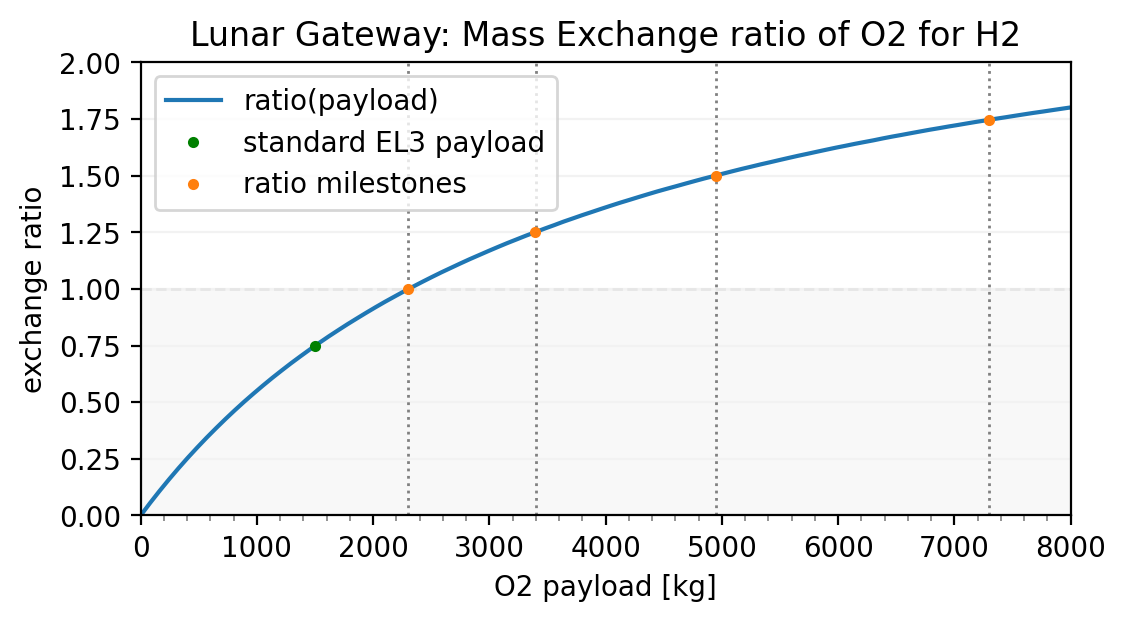

In [222]:
# plot Exchange Ratio: Oxygen for Hydrogen

plt.figure(figsize=(6,3), dpi=200)
plt.title("Lunar Gateway: Mass Exchange ratio of O2 for H2")
plt.xlim(0, max(x_payload))
plt.ylim(0, 2)
plt.axhspan(0, 1, color='0.95', alpha=0.5,ls='--')
plt.grid(axis='y', color='0.95')
plt.axhline(y=1 ,linewidth=1, color='0.9',linestyle="--")
plt.axvline(x=2300 ,linewidth=1, color='0.5',linestyle=":")
plt.axvline(x=3400 ,linewidth=1, color='0.5',linestyle=":")
plt.axvline(x=4950 ,linewidth=1, color='0.5',linestyle=":")
plt.axvline(x=7300,linewidth=1, color='0.5',linestyle=":")
plt.axvline(x=31790,linewidth=1, color='0.5',linestyle=":")
plt.plot(x,ex_ratio,label='ratio(payload)')
plt.plot(x_points[0],y2_points_ratio[0],'.',color='g',label='standard EL3 payload')
plt.plot(x_points[1:],y2_points_ratio[1:],'.',label='ratio milestones')
plt.ylabel("exchange ratio")
plt.xlabel("O2 payload [kg]")
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.xaxis.set_minor_locator(MultipleLocator(200))
ax.tick_params(axis='x', which='minor', colors='0.5')
#for label in ax.xaxis.get_ticklabels()[::2]:
#    label.set_visible(False)
plt.savefig('doc\\img\\upscale_ex_ratio.pdf', dpi=300,facecolor ='white', bbox_inches='tight',pad_inches = 0)
plt.show()

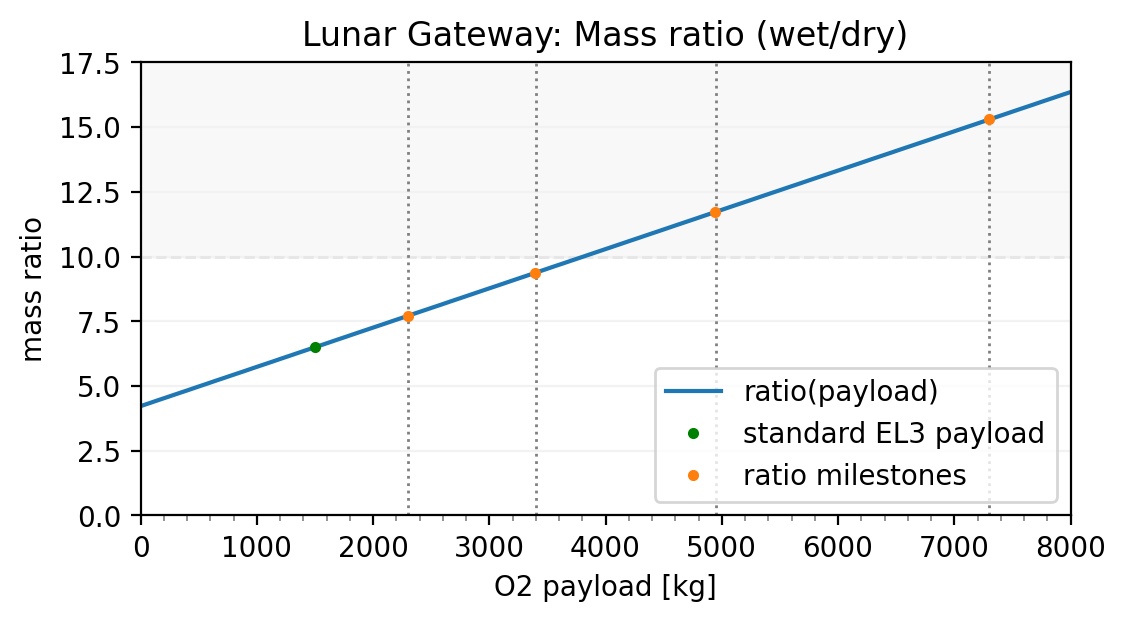

In [223]:
# plot wet_mass for operating points compared to standard EL3
plt.figure(figsize=(6,3), dpi=200)
plt.title("Lunar Gateway: Mass ratio (wet/dry)")
plt.xlim(0, max(x_payload))
plt.ylim(0, 17.5)
plt.axhspan(10, 20, color='0.95', alpha=0.5,ls='--')
plt.grid(axis='y', color='0.95')
plt.axhline(y=10 ,linewidth=1, color='0.9',linestyle="--")
plt.axvline(x=2300 ,linewidth=1, color='0.5',linestyle=":")
plt.axvline(x=3400 ,linewidth=1, color='0.5',linestyle=":")
plt.axvline(x=4950 ,linewidth=1, color='0.5',linestyle=":")
plt.axvline(x=7300,linewidth=1, color='0.5',linestyle=":")
plt.axvline(x=31790,linewidth=1, color='0.5',linestyle=":")
plt.plot(x,m_ratio,label='ratio(payload)')
plt.plot(x_points[0],y1_points_ratio[0],'.',color='g',label='standard EL3 payload')
plt.plot(x_points[1:],y1_points_ratio[1:],'.',label='ratio milestones')
plt.ylabel("mass ratio")
plt.xlabel("O2 payload [kg]")
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.xaxis.set_minor_locator(MultipleLocator(200))
ax.tick_params(axis='x', which='minor', colors='0.5')
#for label in ax.xaxis.get_ticklabels()[::2]:
#    label.set_visible(False)
plt.savefig('doc\\img\\upscale_m_ratio.pdf', dpi=300,facecolor ='white', bbox_inches='tight',pad_inches = 0)
plt.show()

### A) upscaled version with **1.25** exchange ratio

#### dv Maximum

In [32]:
Launcher_dry_mass = 1600
Launcher_payload = 3390
Launcher_wet_mass , Launcher_H2_refill, Launcher_H2_initial = converge_NRHO_roundtrip(Launcher_payload,np.max(dv_map_NRHO),info=True)
Launcher_O2_refill = Launcher_wet_mass - Launcher_dry_mass - Launcher_payload - Launcher_H2_initial

print("LAUNCHER SPECIFICATION - for global dv Maximum")
x = PrettyTable(header=False)
x.set_style(SINGLE_BORDER)
x.add_row(["wet mass", f'{Launcher_wet_mass:7.0f} [kg]'])
x.add_row(["dry mass", f'{Launcher_dry_mass:7.0f} [kg]'])
x.add_row(["payload", f'{Launcher_payload:7.0f} [kg]'])
x.add_row(["O2 refill", f'{Launcher_O2_refill:7.0f} [kg]'])
x.add_row(["H2 refill", f'{Launcher_H2_refill:7.0f} [kg]'])
x.add_row(["Mass Ratio", f'{Launcher_wet_mass/Launcher_dry_mass:7.3f}     '])
x.add_row(["Exchange Ratio", f'{Launcher_payload/Launcher_H2_refill:7.3f}     '])
print(x)

14982  1859  2711 True True       
|                  |    ΔV    | used fuel |  Δ H2 |  Δ O2 |  mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:--------:|:---------:|:-----:|:-----:|:-----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |          |           |       | +8133 | 14982 |    9992   | 1859 | 8133 |  +3390  |
|    Maneuvers     | 2690.005 |    7435   | -1859 | -5577 |  7547 |    2557   |    0 | 2556 |         |
| Gateway exchange |          |           | +2711 |       |  6868 |    5268   | 2711 | 2556 |  -3390  |
|    Maneuvers     | 2690.005 |    3408   |  -852 | -2556 |  6849 |    1859   | 1859 |    0 |         |
| === SUCCESS ===  |   ====   |    ====   |  ==== |  ==== |  ==== |    ====   | ==== | ==== |   ====  |
 
LAUNCHER SPECIFICATION - for global dv Maximum
┌────────────────┬──────────────┐
│    wet mass    │   14982 [kg] │
│    dry mass    │    1600 [kg] │
│    payload     │    3390 [kg] │
│   O2 refill    │    8133 [kg] │
│   H2 refill    │

#### dv Minimum

In [31]:
Launcher_dry_mass = 1600
Launcher_payload = 3285
Launcher_wet_mass , Launcher_H2_refill, Launcher_H2_initial = converge_NRHO_roundtrip(Launcher_payload,np.min(dv_map_NRHO),info=True)
Launcher_O2_refill = Launcher_wet_mass - Launcher_dry_mass - Launcher_payload - Launcher_H2_initial

print("LAUNCHER SPECIFICATION - for global dv Minimum")
x = PrettyTable(header=False)
x.set_style(SINGLE_BORDER)
x.add_row(["wet mass", f'{Launcher_wet_mass:7.0f} [kg]'])
x.add_row(["dry mass", f'{Launcher_dry_mass:7.0f} [kg]'])
x.add_row(["payload", f'{Launcher_payload:7.0f} [kg]'])
x.add_row(["O2 refill", f'{Launcher_O2_refill:7.0f} [kg]'])
x.add_row(["H2 refill", f'{Launcher_H2_refill:7.0f} [kg]'])
x.add_row(["Mass Ratio", f'{Launcher_wet_mass/Launcher_dry_mass:7.3f}     '])
x.add_row(["Exchange Ratio", f'{Launcher_payload/Launcher_H2_refill:7.3f}     '])
print(x)

14567  1799  2628 True True           
|                  |     ΔV    | used fuel |  Δ H2 |  Δ O2 |  mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:---------:|:---------:|:-----:|:-----:|:-----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |           |           |       | +7883 | 14567 |    9682   | 1799 | 7883 |  +3285  |
|    Maneuvers     | 2670.8103 |    7194   | -1798 | -5395 |  7373 |    2488   |    1 | 2488 |         |
| Gateway exchange |           |           | +2628 |       |  6716 |    5116   | 2629 | 2488 |  -3285  |
|    Maneuvers     | 2670.8103 |    3317   |  -829 | -2488 |  6685 |    1800   | 1799 |    0 |         |
| === SUCCESS ===  |    ====   |    ====   |  ==== |  ==== |  ==== |    ====   | ==== | ==== |   ====  |
 
LAUNCHER SPECIFICATION - for global dv Minimum
┌────────────────┬──────────────┐
│    wet mass    │   14567 [kg] │
│    dry mass    │    1600 [kg] │
│    payload     │    3285 [kg] │
│   O2 refill    │    7883 [kg] │
│   H2 

### B) upscaled version with **1.5** exchange ratio

#### dv Maximum

In [208]:
Launcher_dry_mass = 1600
Launcher_payload = 4945
Launcher_wet_mass , Launcher_H2_refill, Launcher_H2_initial = converge_NRHO_roundtrip(Launcher_payload,np.max(dv_map_NRHO),info=True)
Launcher_O2_refill = Launcher_wet_mass - Launcher_dry_mass - Launcher_payload - Launcher_H2_initial

print("LAUNCHER SPECIFICATION - for global dv Maximum")
x = PrettyTable(header=False)
x.set_style(SINGLE_BORDER)
x.add_row(["wet mass", f'{Launcher_wet_mass:7.0f} [kg]'])
x.add_row(["dry mass", f'{Launcher_dry_mass:7.0f} [kg]'])
x.add_row(["payload", f'{Launcher_payload:7.0f} [kg]'])
x.add_row(["O2 refill", f'{Launcher_O2_refill:7.0f} [kg]'])
x.add_row(["H2 refill", f'{Launcher_H2_refill:7.0f} [kg]'])
x.add_row(["Mass Ratio", f'{Launcher_wet_mass/Launcher_dry_mass:7.3f}     '])
x.add_row(["Exchange Ratio", f'{Launcher_payload/Launcher_H2_refill:7.3f}     '])
print(x)

18759  2328  3296 True True        
|                  |    ΔV    | used fuel |  Δ H2 |  Δ O2 |  mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:--------:|:---------:|:-----:|:-----:|:-----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |          |           |       | +9886 | 18759 |   12214   | 2328 | 9886 |  +4945  |
|    Maneuvers     | 2690.005 |    9310   | -2327 | -6982 |  9449 |    2904   |    1 | 2904 |         |
| Gateway exchange |          |           | +3296 |       |  7800 |    6200   | 3297 | 2904 |  -4945  |
|    Maneuvers     | 2690.005 |    3871   |  -968 | -2903 |  8874 |    2329   | 2329 |    0 |         |
| === SUCCESS ===  |   ====   |    ====   |  ==== |  ==== |  ==== |    ====   | ==== | ==== |   ====  |
 
LAUNCHER SPECIFICATION - for global dv Maximum
┌────────────────┬──────────────┐
│    wet mass    │   18759 [kg] │
│    dry mass    │    1600 [kg] │
│    payload     │    4945 [kg] │
│   O2 refill    │    9886 [kg] │
│   H2 refill    

#### dv Minimum (keep Mass Ratio constant)

In [217]:
Launcher_dry_mass = 1600
Launcher_payload = 5029
Launcher_wet_mass , Launcher_H2_refill, Launcher_H2_initial = converge_NRHO_roundtrip(Launcher_payload,np.min(dv_map_NRHO),info=True)
Launcher_O2_refill = Launcher_wet_mass - Launcher_dry_mass - Launcher_payload - Launcher_H2_initial

print("LAUNCHER SPECIFICATION - for global dv Minimum")
x = PrettyTable(header=False)
x.set_style(SINGLE_BORDER)
x.add_row(["wet mass", f'{Launcher_wet_mass:7.0f} [kg]'])
x.add_row(["dry mass", f'{Launcher_dry_mass:7.0f} [kg]'])
x.add_row(["payload", f'{Launcher_payload:7.0f} [kg]'])
x.add_row(["O2 refill", f'{Launcher_O2_refill:7.0f} [kg]'])
x.add_row(["H2 refill", f'{Launcher_H2_refill:7.0f} [kg]'])
x.add_row(["Mass Ratio", f'{Launcher_wet_mass/Launcher_dry_mass:7.3f}     '])
x.add_row(["Exchange Ratio", f'{Launcher_payload/Launcher_H2_refill:7.3f}     '])
print(x)

18758  2316  3271 True True       
|                  |     ΔV    | used fuel |  Δ H2 |  Δ O2 |  mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:---------:|:---------:|:-----:|:-----:|:-----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |           |           |       | +9813 | 18758 |   12129   | 2316 | 9813 |  +5029  |
|    Maneuvers     | 2670.8103 |    9263   | -2316 | -6947 |  9495 |    2866   |    0 | 2866 |         |
| Gateway exchange |           |           | +3271 |       |  7737 |    6137   | 3271 | 2866 |  -5029  |
|    Maneuvers     | 2670.8103 |    3821   |  -955 | -2865 |  8945 |    2316   | 2316 |    0 |         |
| === SUCCESS ===  |    ====   |    ====   |  ==== |  ==== |  ==== |    ====   | ==== | ==== |   ====  |
 
LAUNCHER SPECIFICATION - for global dv Minimum
┌────────────────┬──────────────┐
│    wet mass    │   18758 [kg] │
│    dry mass    │    1600 [kg] │
│    payload     │    5029 [kg] │
│   O2 refill    │    9813 [kg] │
│   H2 refi

## Mass Costs per Year

In [229]:
# both (min/max) using up the 23.9 t Oxygen per year

# apply 23.9 t Oxygen Supply
# B) 1.5
#             MAXIMUM dv
#┌────────────────┬──────────────┐
#│    wet mass    │   18759 [kg] │
#│    dry mass    │    1600 [kg] │
#│    payload     │    4945 [kg] │
#│   O2 refill    │    9886 [kg] │
#│   H2 refill    │    3296 [kg] │
#│   Mass Ratio   │  11.724      │
#│ Exchange Ratio │   1.500      │
#└────────────────┴──────────────┘
#             MINIMUM dv
#┌────────────────┬──────────────┐
#│    wet mass    │   18758 [kg] │
#│    dry mass    │    1600 [kg] │
#│    payload     │    5029 [kg] │
#│   O2 refill    │    9813 [kg] │
#│   H2 refill    │    3271 [kg] │
#│   Mass Ratio   │  11.724      │
#│ Exchange Ratio │   1.537      │
#└────────────────┴──────────────┘

# compare fuel costs for delivering the same amount of payload [1kg]
maxdv_payload = 4945 # [kg]
maxdv_O2_consumption = 9886 # [kg]
maxdv_H2_consumption = 3296 # [kg]
maxdv_Fuel_consumption = maxdv_O2_consumption + maxdv_H2_consumption
maxdv_costs_per_kg = maxdv_Fuel_consumption / maxdv_payload

print(f'maxdv_costs_per_kg = {maxdv_costs_per_kg:5.3f} [kg Fuel/ kg Payload]')

mindv_payload = 5029 # [kg]
mindv_O2_consumption = 9813 # [kg]
mindv_H2_consumption = 3271 # [kg]
mindv_Fuel_consumption = mindv_O2_consumption + mindv_H2_consumption
mindv_costs_per_kg = mindv_Fuel_consumption / mindv_payload

print(f'mindv_costs_per_kg = {mindv_costs_per_kg:5.3f} [kg Fuel/ kg Payload]')
print()

maxdv_costs_per_year = 23.9 * 1000 * maxdv_costs_per_kg

print(f'maxdv_costs_per_year = {maxdv_costs_per_year:5.2f} [kg Fuel/ year]')

mindv_costs_per_year = 23.9 * 1000 * mindv_costs_per_kg

print(f'mindv_costs_per_year = {mindv_costs_per_year:5.2f} [kg Fuel/ year]')

maxdv_costs_per_kg = 2.666 [kg Fuel/ kg Payload]
mindv_costs_per_kg = 2.602 [kg Fuel/ kg Payload]

maxdv_costs_per_year = 63710.78 [kg Fuel/ year]
mindv_costs_per_year = 62180.87 [kg Fuel/ year]


## Cost per year map
as converge_NRHO_roundtrip() takes ~2 sec to finish an iterative solving of the (23040, 11520) data is not practical (16.8 years)
<br>
however the relationship from dv to the costs per kg can be sampled into a fitting function to supply an easy mapping

### fitting data
vary dv and keep mass ratio constant

In [36]:
def cost_from_dv_via_mass_ratio(mass_ratio,dv,start_value):
    tolerance = 0.01
    increment = 10
    
    Launcher_dry_mass = 1600
    Launcher_payload = start_value
    
    while True:
        Launcher_wet_mass , Launcher_H2_refill = converge_NRHO_roundtrip(Launcher_payload,dv,info=False,silent=True)
        Launcher_mass_ratio = Launcher_wet_mass/Launcher_dry_mass
        
        if Launcher_mass_ratio < mass_ratio + tolerance and Launcher_mass_ratio > mass_ratio - tolerance :
            break
        elif Launcher_mass_ratio < mass_ratio:
            Launcher_payload += increment
        elif Launcher_mass_ratio > mass_ratio:
            Launcher_payload -= increment
            
    Launcher_O2_refill = Launcher_wet_mass - Launcher_dry_mass - Launcher_payload - Launcher_H2_initial
    
    Fuel_consumption = Launcher_O2_refill + Launcher_H2_refill
    costs_per_kg = Fuel_consumption / Launcher_payload
    
    return costs_per_kg

In [180]:
# takes approx. 13 min to complete
mass_ratio_1_25 = 9.364
mass_ratio_1_5 = 11.724
x = np.linspace(np.min(dv_map_NRHO),np.max(dv_map_NRHO),100)
y_1_25 = []
y_1_5 = []
for i in tqdm(x):
    y_1_25.append(cost_from_dv_via_mass_ratio(mass_ratio_1_25,i,start_value=3300))
    y_1_5.append(cost_from_dv_via_mass_ratio(mass_ratio_1_5,i,start_value=4980))

  0%|          | 0/100 [00:00<?, ?it/s]

f(x)_1.25 = 0.0046577169283476515*x + -9.329401166094913
f(x)_1.5  = 0.0034506263972919706*x + -6.522764962617154


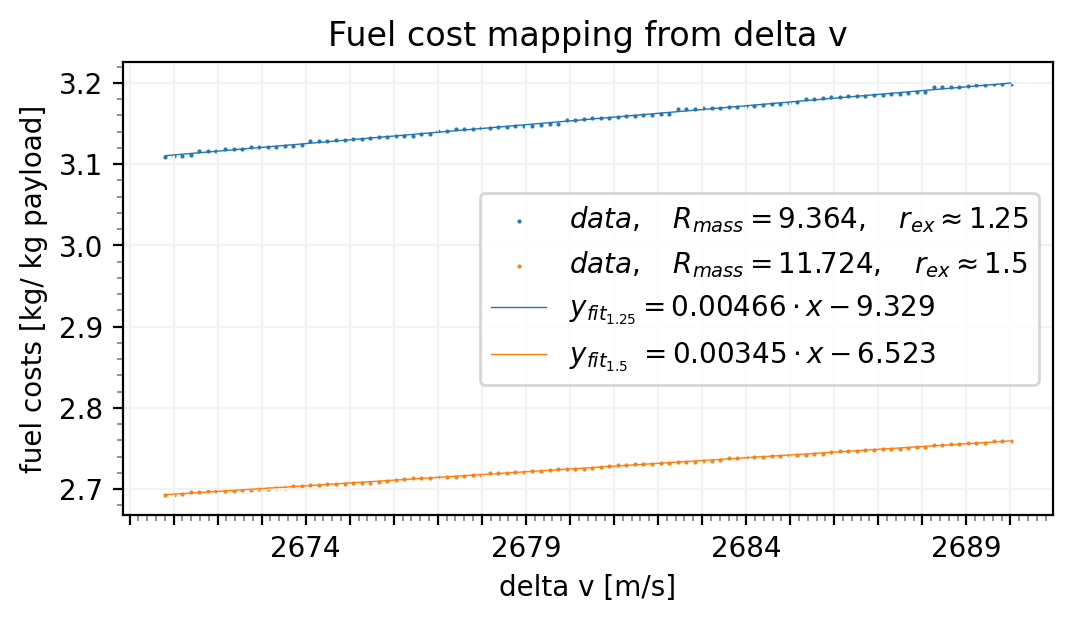

In [210]:
# linear fit
m_1_25, n_1_25 = np.polyfit(x, y_1_25, 1)
m_1_5, n_1_5 = np.polyfit(x, y_1_5, 1)
y_pred_1_25 = m_1_25 * x + n_1_25
y_pred_1_5 = m_1_5 * x + n_1_5
print(f'f(x)_1.25 = {m_1_25}*x + {n_1_25}')
print(f'f(x)_1.5  = {m_1_5}*x + {n_1_5}')

plt.figure(figsize=(6,3), dpi=200)

plt.title("Fuel cost mapping from delta v")
plt.grid(axis='both', color='0.95')

plt.scatter(x,y_1_25,marker='.', s=1, color='tab:blue',label=r'$data, \quad R_{mass}=9.364, \quad r_{ex} \approx 1.25$')
plt.scatter(x,y_1_5,marker='.', s=1, color='tab:orange',label=r'$data, \quad R_{mass}=11.724, \quad r_{ex} \approx 1.5$')

plt.plot(x,y_pred_1_25,label=r'$y_{fit_{1.25}}= 0.00466 \cdot x -9.329$', linewidth=0.5)
plt.plot(x,y_pred_1_5,label=r'$y_{fit_{1.5}} \ = 0.00345 \cdot x -6.523$', linewidth=0.5)

plt.ylabel("fuel costs [kg/ kg payload]")
plt.xlabel("delta v [m/s]")
plt.legend()
ax = plt.gca()
ax.yaxis.set_minor_locator(MultipleLocator(0.02))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
for i, label in enumerate(ax.xaxis.get_ticklabels()):
    if i % 5 != 0:
        label.set_visible(False)
ax.tick_params(axis='y', which='minor', colors='0.5')
ax.tick_params(axis='x', which='minor', colors='0.5')
plt.savefig('doc\\img\\fuel_cost_mapping.pdf', dpi=300,facecolor ='white', bbox_inches='tight',pad_inches = 0)
plt.show()

In [3]:
def fuel_cost_mapping_1_25(dv):
    # m_1_25 = 0.0046577169283476515
    # n_1_25 = -9.329401166094913
    cost = 0.0046577169283476515 * dv -9.329401166094913
    return cost

def fuel_cost_mapping_1_5(dv):
    # m_1_5 = 0.0034506263972919706
    # n_1_5 = -6.522764962617154
    cost = 0.0034506263972919706 * dv -6.522764962617154
    return cost

In [6]:
cost_map_NRHO_1_25 = fuel_cost_mapping_1_25(dv_map_NRHO)
cost_map_NRHO_1_5 = fuel_cost_mapping_1_5(dv_map_NRHO)

In [9]:
# save data in xArray to file (~1GB of space)

Lat, Lon = LatLonfromShape(height_data.shape)

xA_cost_map_NRHO_1_25 = xr.DataArray(
    data=cost_map_NRHO_1_25,
    dims=["lat","lon"],
    coords=dict(
        lon=(["lon"], Lon),
        lat=(["lat"], Lat)
    ),
    attrs=dict(
        description="Fuel Costs per kg payload to Lunar Gateway (NRHO) with an exchange ratio of approx. 1.25 (mass ratio of 9.364)",
        var_desc="fuel costs",
        units="kg",
    ),
)

xA_cost_map_NRHO_1_25.to_netcdf("maps/cost_map_NRHO_1_25.nc")

In [ ]:
# save data in xArray to file (~1GB of space)

Lat, Lon = LatLonfromShape(height_data.shape)

xA_cost_map_NRHO_1_5 = xr.DataArray(
    data=cost_map_NRHO_1_5,
    dims=["lat","lon"],
    coords=dict(
        lon=(["lon"], Lon),
        lat=(["lat"], Lat)
    ),
    attrs=dict(
        description="Fuel Costs per kg payload to Lunar Gateway (NRHO) with an exchange ratio of approx. 1.5 (mass ratio of 11.724)",
        var_desc="fuel costs",
        units="kg",
    ),
)

xA_cost_map_NRHO_1_5.to_netcdf("maps/cost_map_NRHO_1_5.nc")

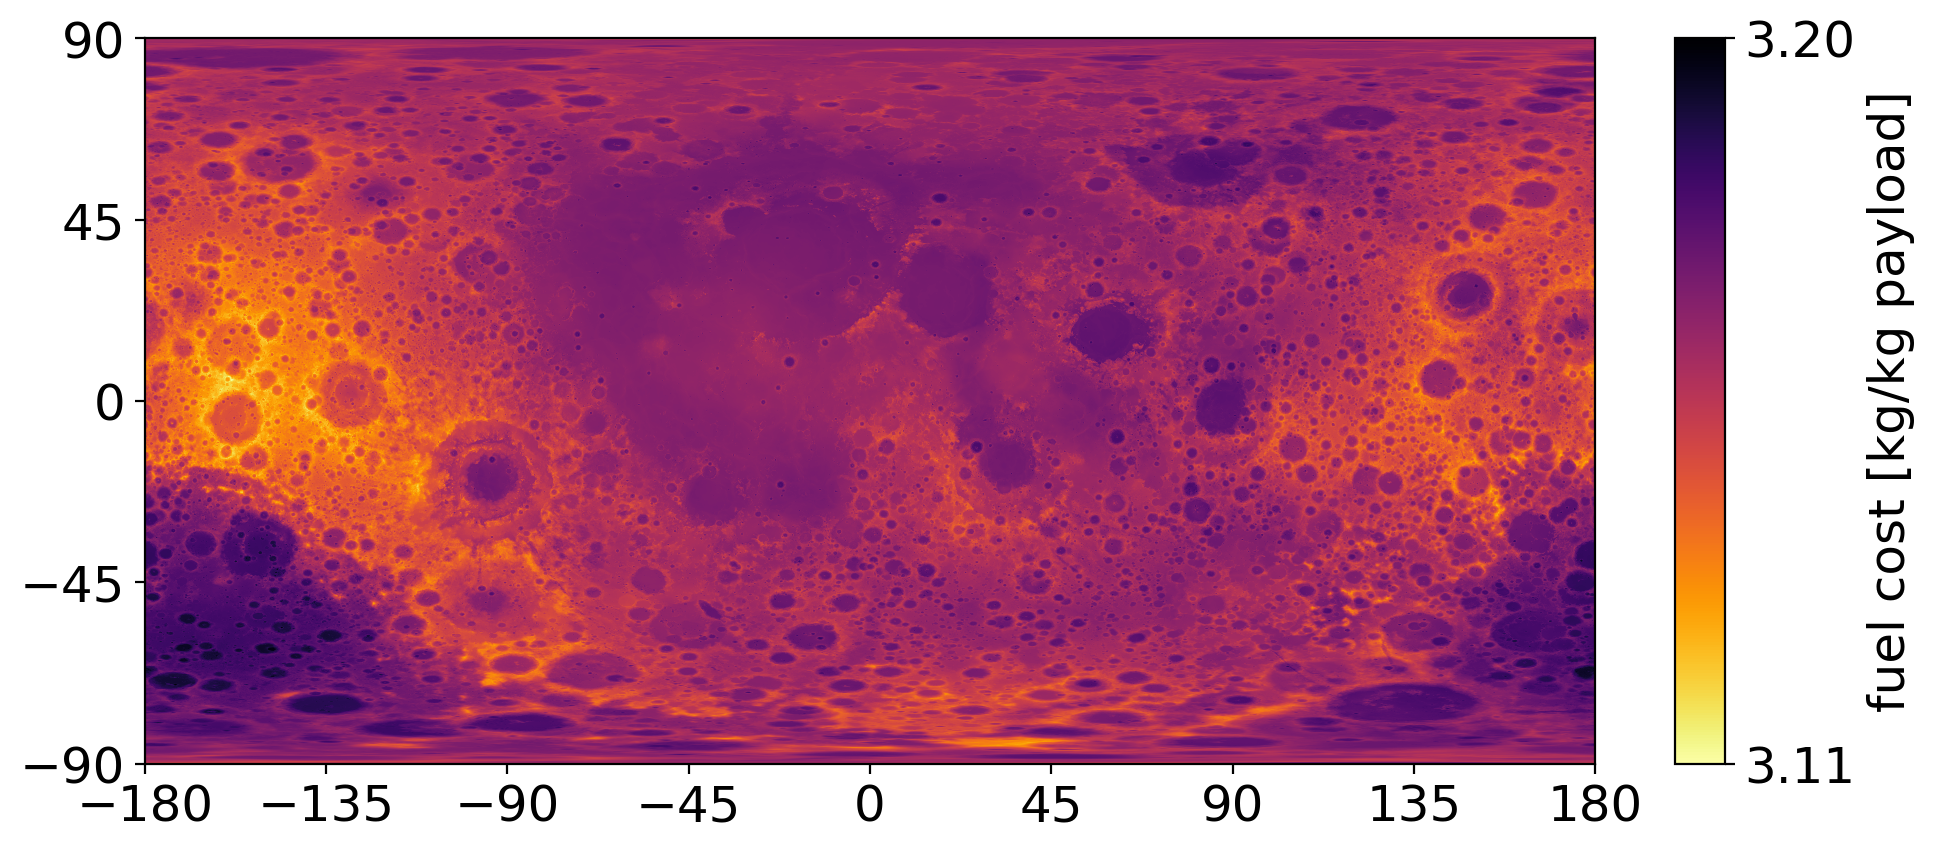

In [11]:
inferno = cm.get_cmap('inferno', 256)
newcolors = inferno(np.linspace(0, 1, 256))
newcmp = ListedColormap(np.flip(newcolors,axis=0))

plot_map(cost_map_NRHO_1_25,1,'fuel cost [kg/kg payload]',tuple((-90,90)),tuple((-180,180)),i_steps=[],cmap=newcmp,silent=True,labelsize=18,save="cost_map_NRHO_1_25.png")

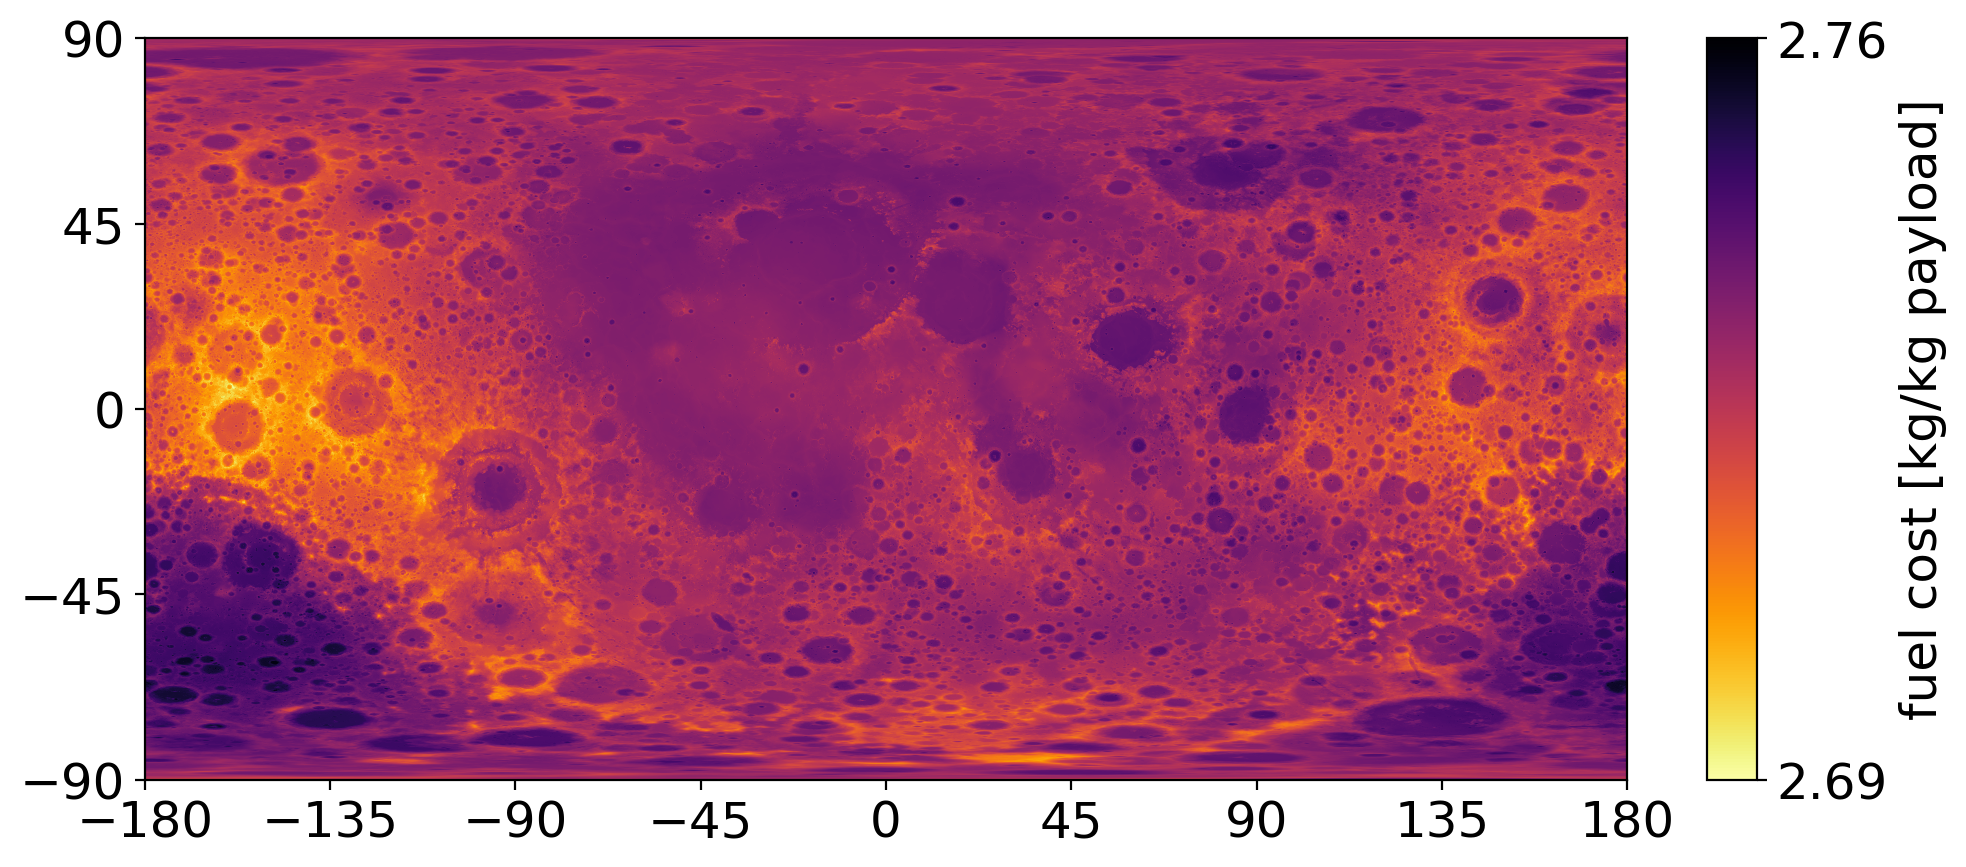

In [13]:
plot_map(cost_map_NRHO_1_5,1,'fuel cost [kg/kg payload]',tuple((-90,90)),tuple((-180,180)),i_steps=[],cmap=newcmp,silent=True,labelsize=18,save="cost_map_NRHO_1_5.png")

## Destination: Low Lunar Orbit (Polar)
> open file "Gateway_PROP_Mass_Point.sc" in STK

## Destination: Lagrange Point (L1) - Earth Moon System
> open file "Gateway_PROP_Mass_Point.sc" in STK

## Destination: Low Earth Orbit (Equatorial) - Starship refuel
> open file "Gateway_PROP_Mass_Point.sc" in STK